In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.8 MB/s eta 0:00:0000:0100:01
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)


In [6]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached Pillow-9.5.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.4 MB)


In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
import inspect

In [164]:
file_path = '../results/CURRENT/stats/*.log'
files = glob.glob(file_path)

column_names = ['ID','Name','CPU_Percentage','Memory_Usage','Memory_Percentage','Net_IO','Block_IO']

# Read all files and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, names=column_names, header=0) for file in files]
df = pd.concat(dataframes, ignore_index=True)


In [148]:
def conv(s):
    # Extract all numbers (including decimals) as strings along with their units
    number_strings_with_units = re.findall(r'(\d+(?:\.\d+)?)([GMKk]?i?B)', s)

    numbers = []
    for num_str, unit in number_strings_with_units:
        num = float(num_str)
        if unit in ['GiB', 'GB']:
            num *= 10**6
        elif unit in ['MiB', 'MB']:
            num *= 10**3
        # elif unit in ['KiB', 'kB', 'KB']:
        #     num *= 10**(-3)
        numbers.append(num)

    return numbers

In [165]:
# Remove "%" sign from columns with percentages
df = df.drop('ID', axis=1)
df['Name'] = df['Name'].apply(str.strip)
df['CPU_Percentage'] = df['CPU_Percentage'].str.replace('%', '').astype(float)
df['Memory_Percentage'] = df['Memory_Percentage'].str.replace('%', '').astype(float)
df['Memory_Usage'] = df['Memory_Usage'].apply(conv)
df['Net_IO'] = df['Net_IO'].apply(conv)
df['Block_IO'] = df['Block_IO'].apply(conv)
df[['Memory_in_use', 'Available_memory']] = pd.DataFrame(df['Memory_Usage'].tolist(), index=df.index)
df[['Net_IO_in', 'Net_IO_out']] = pd.DataFrame(df['Net_IO'].tolist(), index=df.index)
df[['Block_IO_in', 'Block_IO_out']] = pd.DataFrame(df['Block_IO'].tolist(), index=df.index)

In [166]:
df.head()

,Name,CPU_Percentage,Memory_Usage,Memory_Percentage,Net_IO,Block_IO,Memory_in_use,Available_memory,Net_IO_in,Net_IO_out,Block_IO_in,Block_IO_out
0,bfl-ml_client_7,54.24,"[828400.0, 31290000.0]",2.59,"[200000.0, 97000.0]","[254.0, 217.0]",828400.0,31290000.0,200000.0,97000.0,254.0,217.0
1,bfl-ml_client_10,90.54,"[885800.0, 31290000.0]",2.76,"[191000.0, 103000.0]","[2520.0, 229.0]",885800.0,31290000.0,191000.0,103000.0,2520.0,229.0
2,bfl-ml_client_6,65.18,"[843600.0, 31290000.0]",2.63,"[173000.0, 87000.0]","[28.7, 229.0]",843600.0,31290000.0,173000.0,87000.0,28.7,229.0
3,bfl-ml_client_9,65.21,"[778000.0, 31290000.0]",2.43,"[181000.0, 94800.0]","[172.0, 225.0]",778000.0,31290000.0,181000.0,94800.0,172.0,225.0
4,bfl-ml_client_2,93.71,"[748000.0, 31290000.0]",2.33,"[185000.0, 97900.0]","[12.3, 221.0]",748000.0,31290000.0,185000.0,97900.0,12.3,221.0


In [136]:
df_client1 = df.loc[df['Name'] == 'bfl-ml_client_1']
df_client1 = df_client1.drop('Name', axis=1)

In [137]:
df_client1.head()

,CPU_Percentage,Memory_Usage,Memory_Percentage,Net_IO,Block_IO
7,63.63,"[795300.0, 31290000.0]",2.48,"[202000.0, 106000.0]","[467.0, 217.0]"
29,81.42,"[795300.0, 31290000.0]",2.48,"[202000.0, 106000.0]","[467.0, 217.0]"
51,56.07,"[795300.0, 31290000.0]",2.48,"[202000.0, 106000.0]","[467.0, 217.0]"
73,77.15,"[795400.0, 31290000.0]",2.48,"[202000.0, 106000.0]","[467.0, 217.0]"
95,54.00,"[795400.0, 31290000.0]",2.48,"[202000.0, 106000.0]","[467.0, 217.0]"


In [199]:
def classify(input_string):
    if "client" in input_string:
        return "Trainer"
    elif "miner" in input_string:
        return "Miner"
    elif "server" in input_string:
        return "Aggregator"
    elif "rpc-endpoint" in input_string:
        return "RPC Endpoint"
    else:
        return "Unknown"

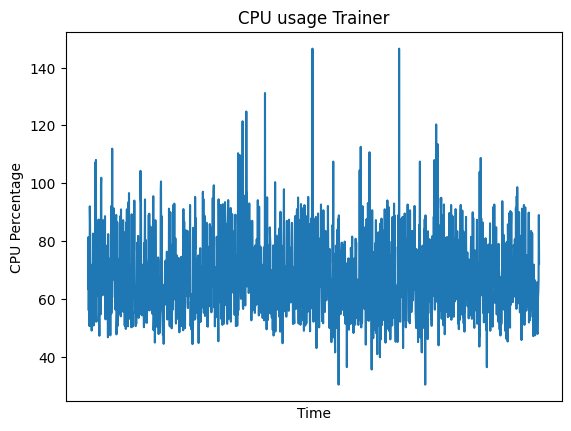

In [215]:
def do_cpu(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]
    plt.plot(df_1['CPU_Percentage'])
    plt.title('CPU usage {}'.format(classify(name)))
    plt.xlabel('Time')
    plt.ylabel('CPU Percentage')
    plt.gca().set_xticks([])
    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_cpu('bfl-ml_client_1', df)


/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

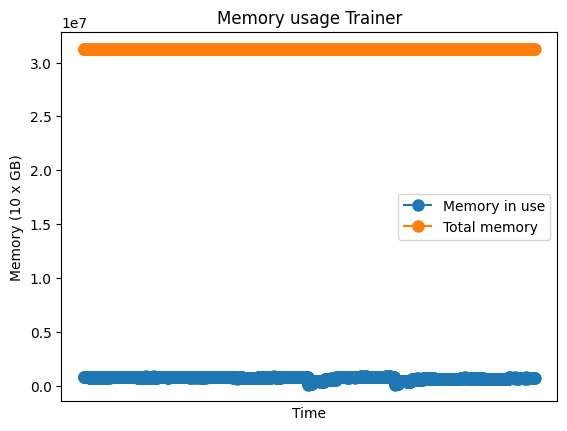

In [216]:

def do_mem(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]
    ax = df_1.plot( y=['Memory_in_use', 'Available_memory'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Memory (10 x GB)')
    ax.set_title('Memory usage {}'.format(classify(name)))

    plt.legend(['Memory in use', 'Total memory'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_mem('bfl-ml_client_1', df)

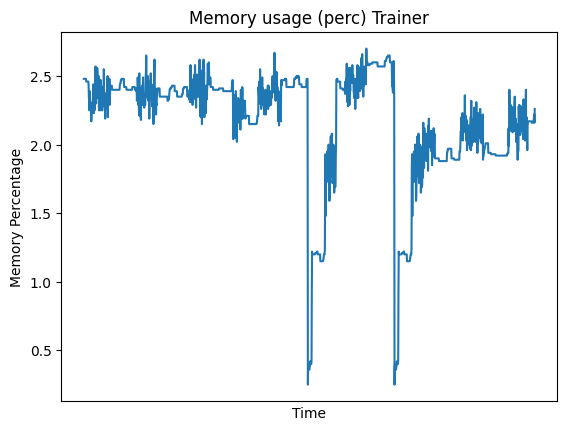

In [217]:
def do_mem_perc(name, df):
    plt.figure()
    plt.title('Memory usage (perc) {}'.format(classify(name)))
    df_1 = df.loc[df['Name'] == name]
    plt.plot(df_1['Memory_Percentage'])
    plt.xlabel('Time')
    plt.ylabel('Memory Percentage')
    plt.gca().set_xticks([])
    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_mem_perc('bfl-ml_client_1', df)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

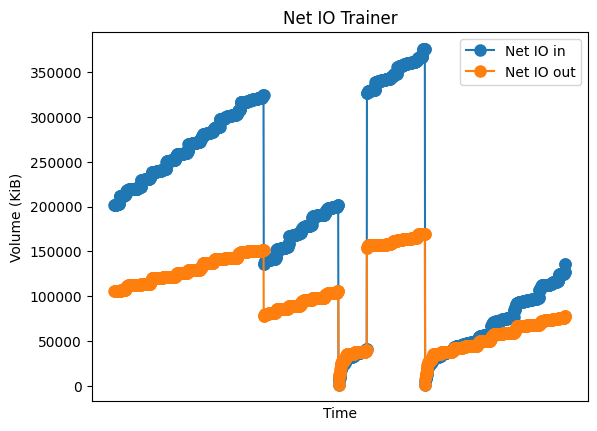

In [218]:
def do_io(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]

    ax = df_1.plot( y=['Net_IO_in', 'Net_IO_out'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Volume (KiB)')
    ax.set_title('Net IO {}'.format(classify(name)))

    plt.legend(['Net IO in', 'Net IO out'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_io('bfl-ml_client_1', df)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

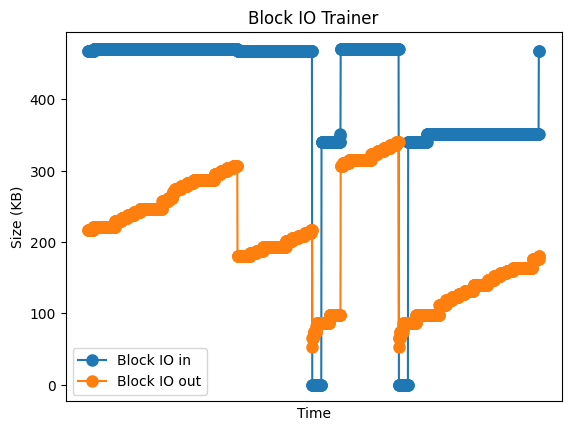

In [219]:
def do_block_io(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]

    ax = df_1.plot( y=['Block_IO_in', 'Block_IO_out'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Size (KB)')
    ax.set_title('Block IO {}'.format(classify(name)))

    plt.legend(['Block IO in', 'Block IO out'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_block_io('bfl-ml_client_1', df)

In [191]:
names = df['Name'].unique()
names.sort()

In [198]:
names

array(['bfl-ml_client_1', 'bfl-ml_client_10', 'bfl-ml_client_2',
       'bfl-ml_client_3', 'bfl-ml_client_4', 'bfl-ml_client_5',
       'bfl-ml_client_6', 'bfl-ml_client_7', 'bfl-ml_client_8',
       'bfl-ml_client_9', 'bfl-ml_server_1', 'bfl_geth-miner_1',
       'bfl_geth-miner_10', 'bfl_geth-miner_2', 'bfl_geth-miner_3',
       'bfl_geth-miner_4', 'bfl_geth-miner_5', 'bfl_geth-miner_6',
       'bfl_geth-miner_7', 'bfl_geth-miner_8', 'bfl_geth-miner_9',
       'bfl_geth-rpc-endpoint_1'], dtype=object)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keywo

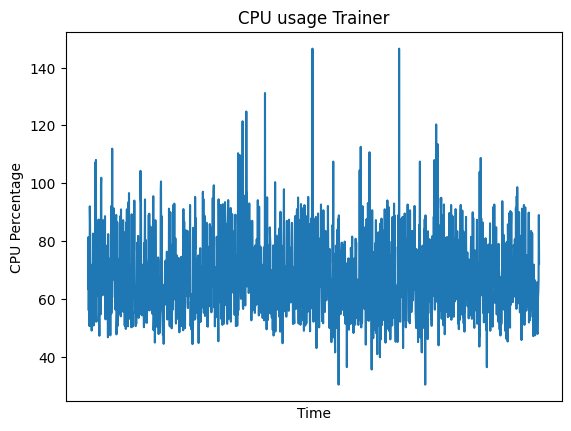

<Figure size 640x480 with 0 Axes>

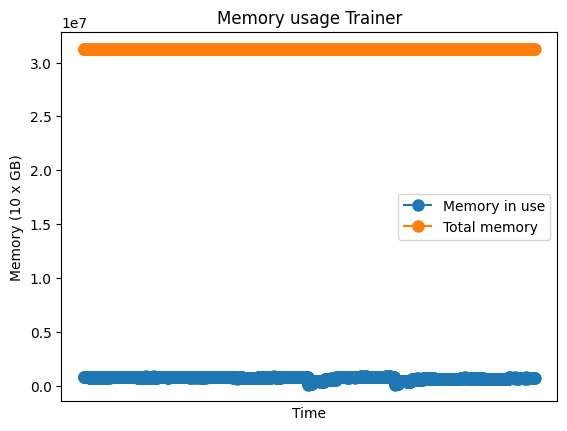

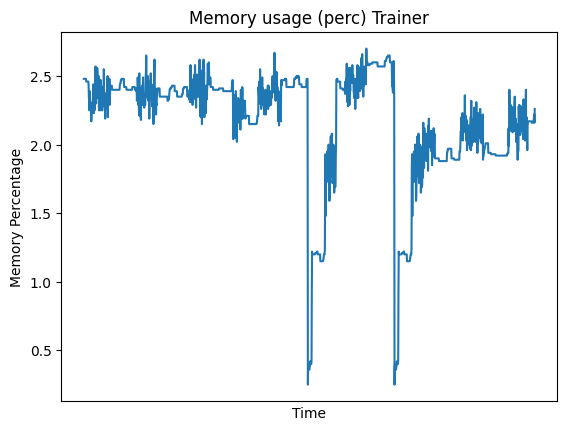

<Figure size 640x480 with 0 Axes>

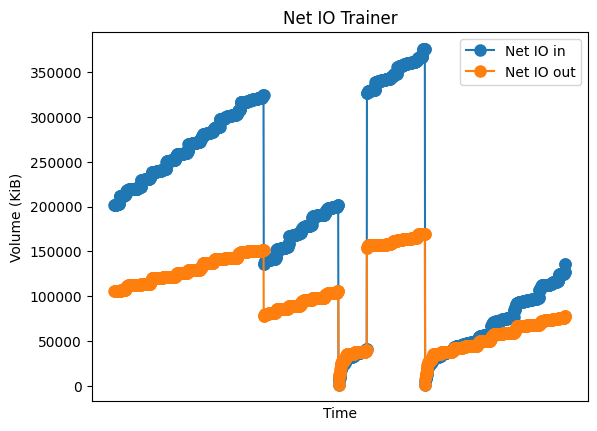

<Figure size 640x480 with 0 Axes>

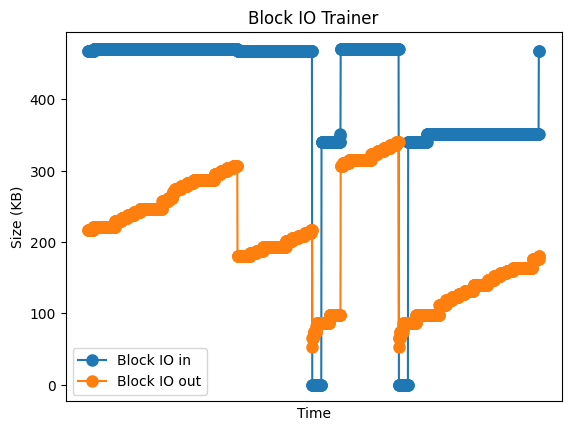

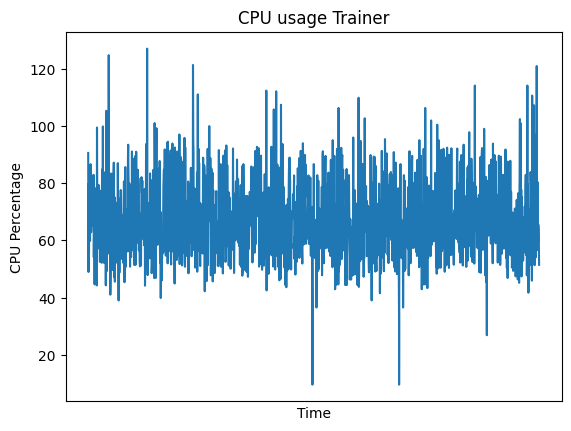

<Figure size 640x480 with 0 Axes>

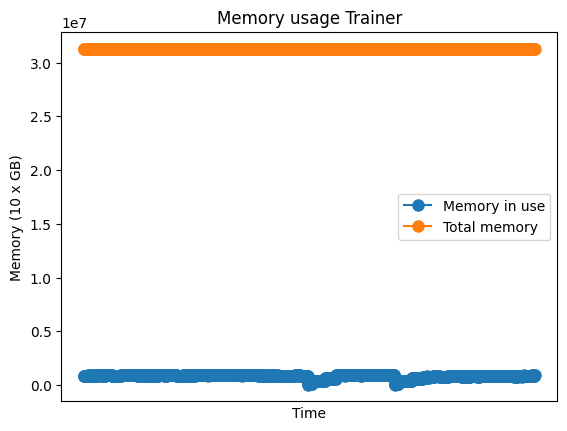

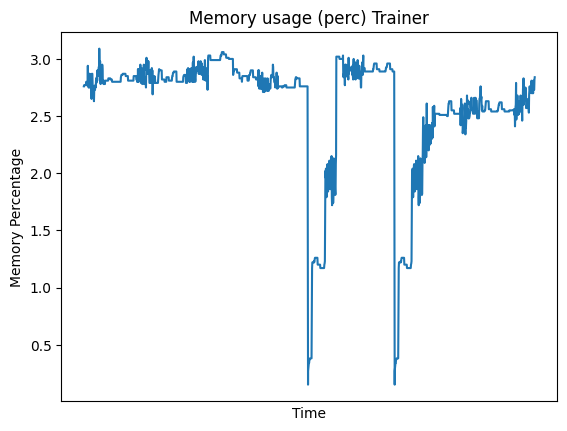

<Figure size 640x480 with 0 Axes>

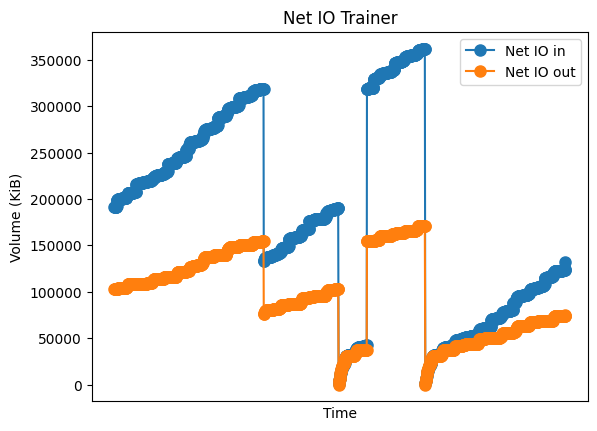

<Figure size 640x480 with 0 Axes>

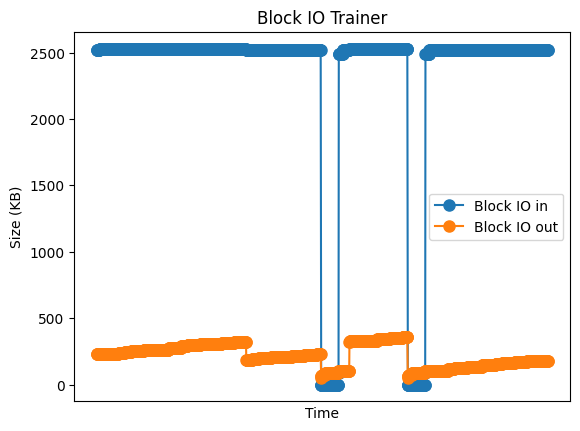

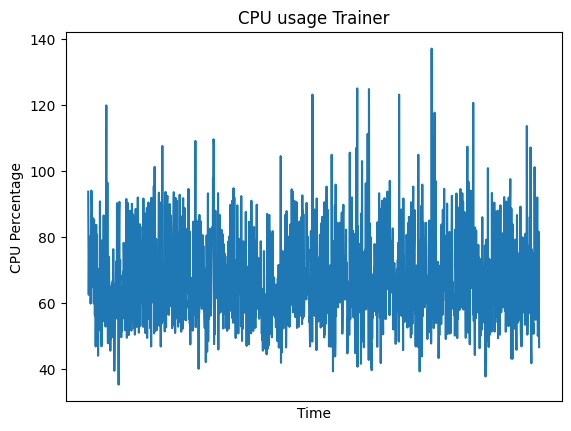

<Figure size 640x480 with 0 Axes>

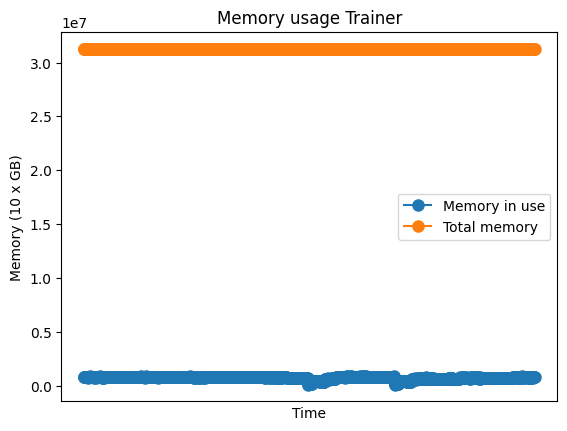

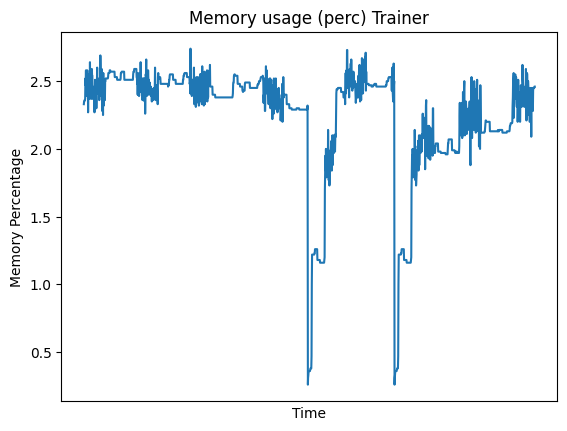

<Figure size 640x480 with 0 Axes>

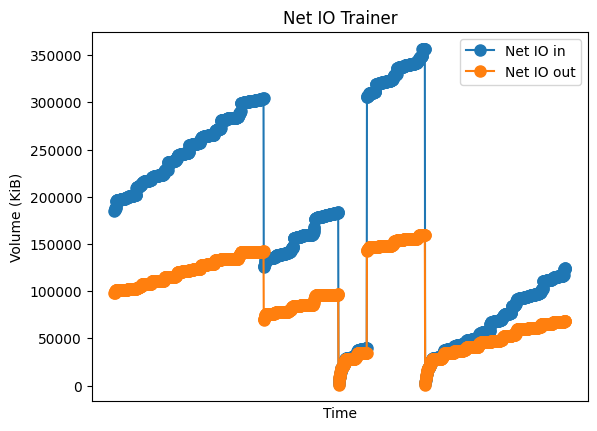

<Figure size 640x480 with 0 Axes>

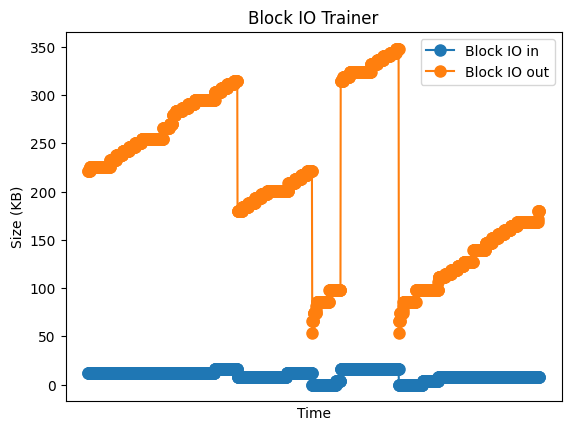

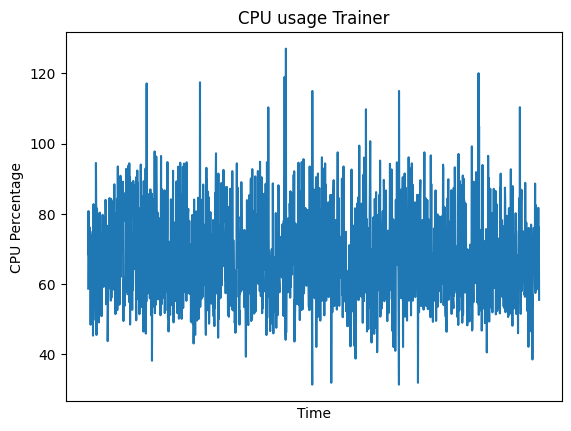

<Figure size 640x480 with 0 Axes>

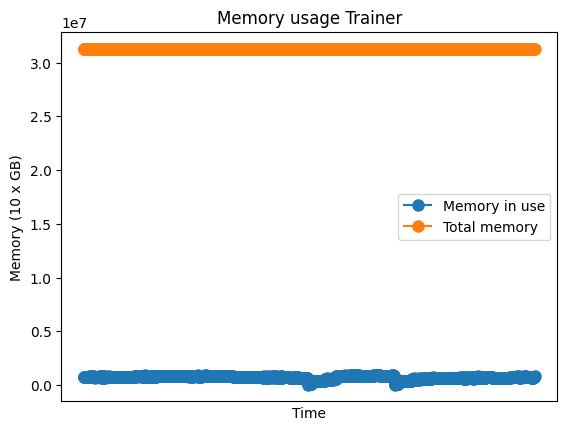

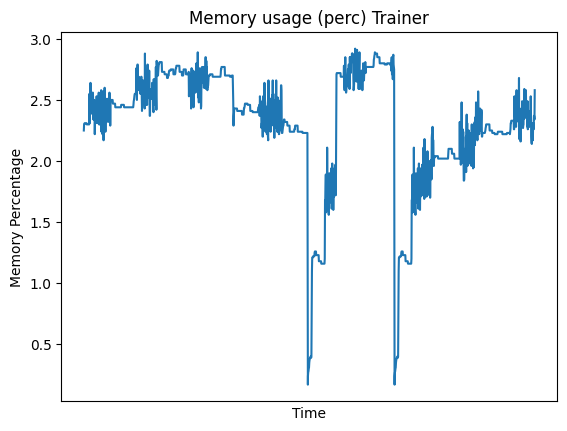

<Figure size 640x480 with 0 Axes>

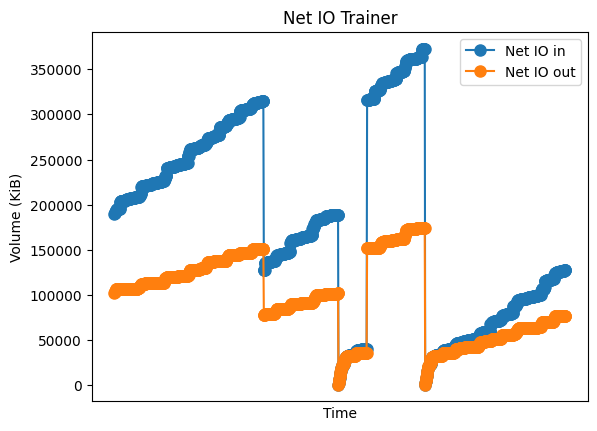

<Figure size 640x480 with 0 Axes>

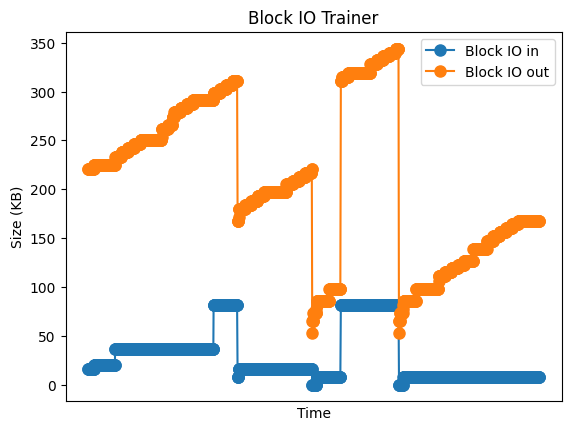

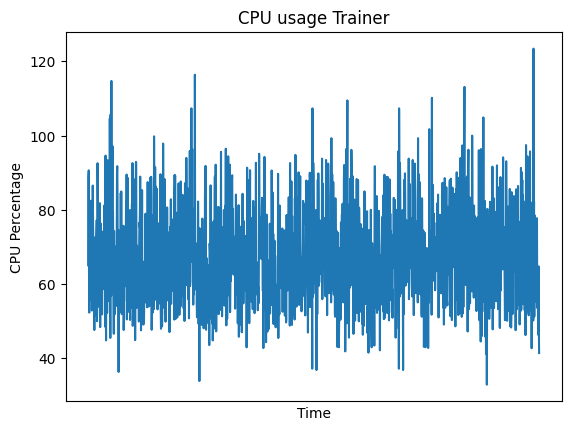

<Figure size 640x480 with 0 Axes>

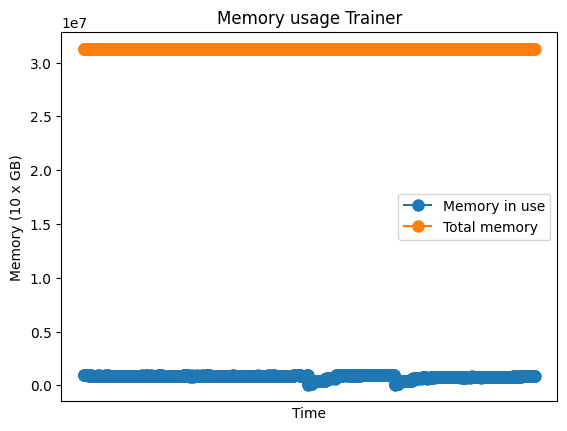

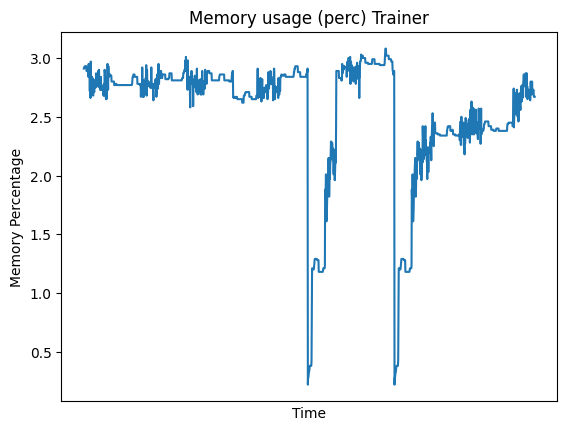

<Figure size 640x480 with 0 Axes>

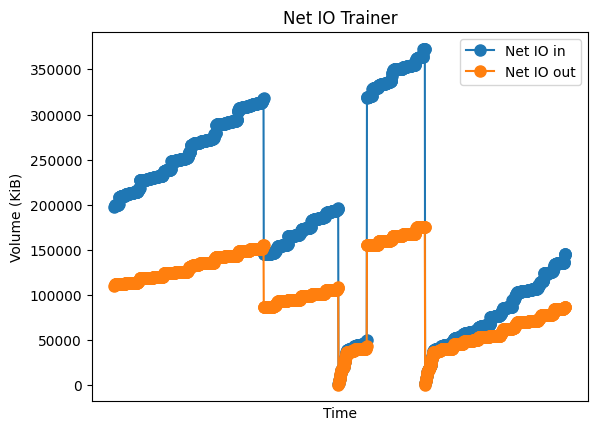

<Figure size 640x480 with 0 Axes>

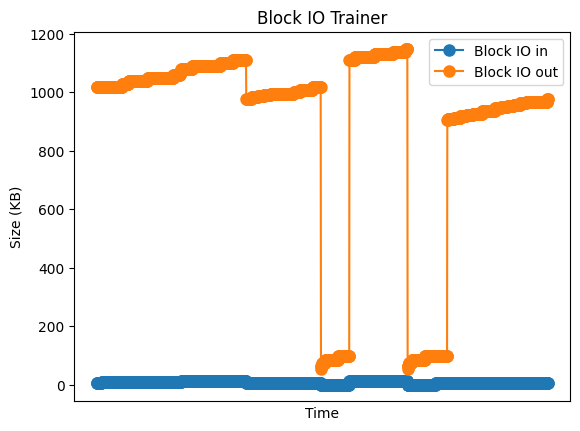

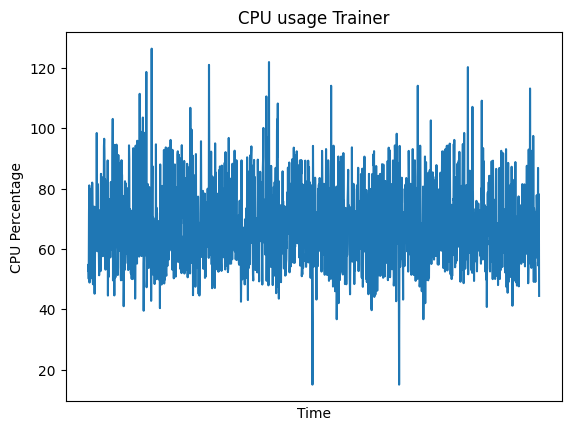

<Figure size 640x480 with 0 Axes>

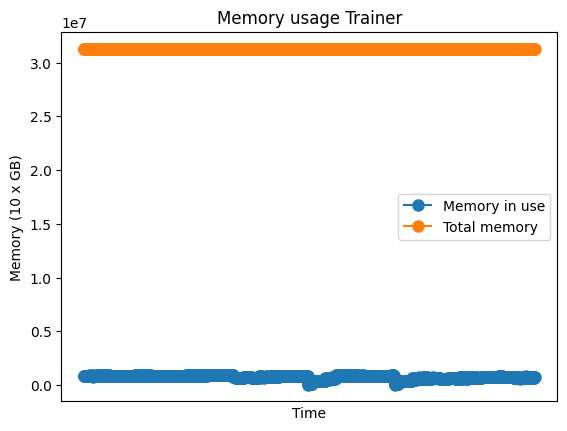

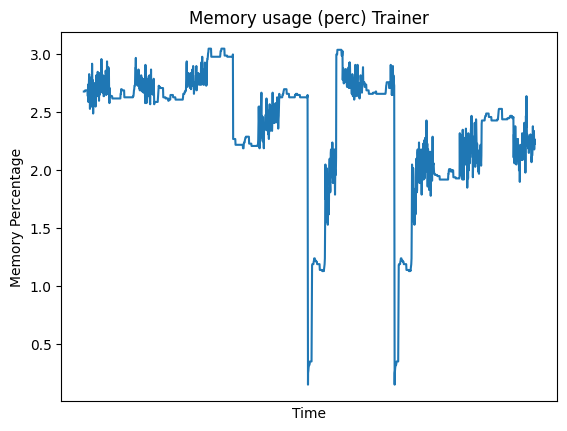

<Figure size 640x480 with 0 Axes>

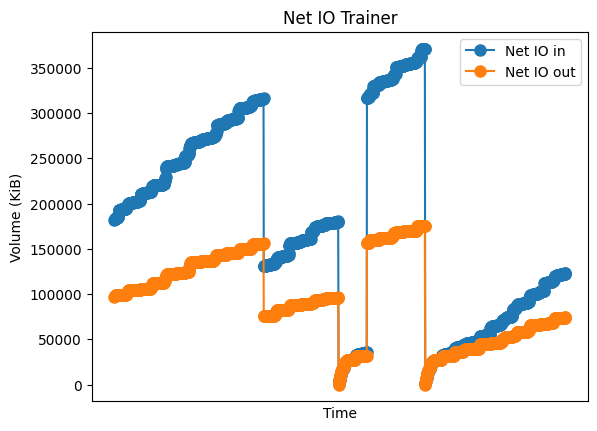

<Figure size 640x480 with 0 Axes>

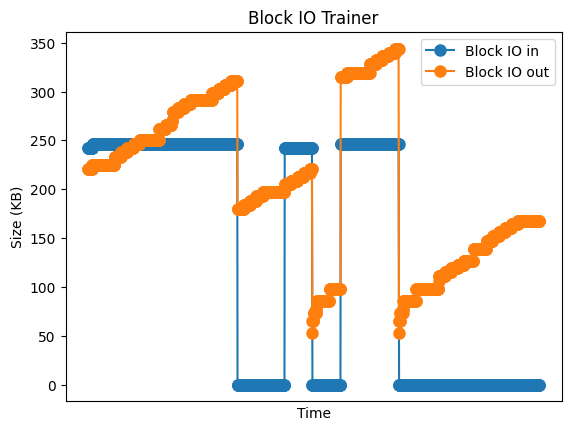

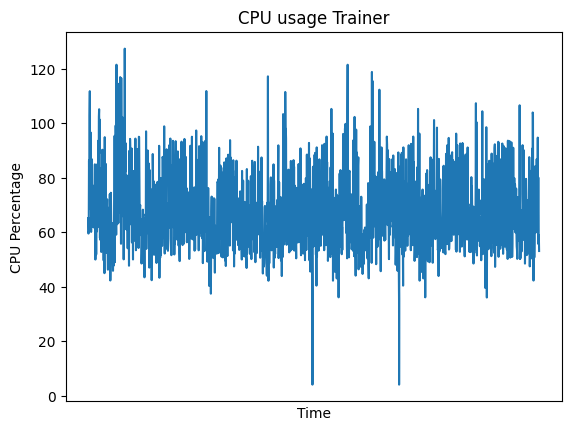

<Figure size 640x480 with 0 Axes>

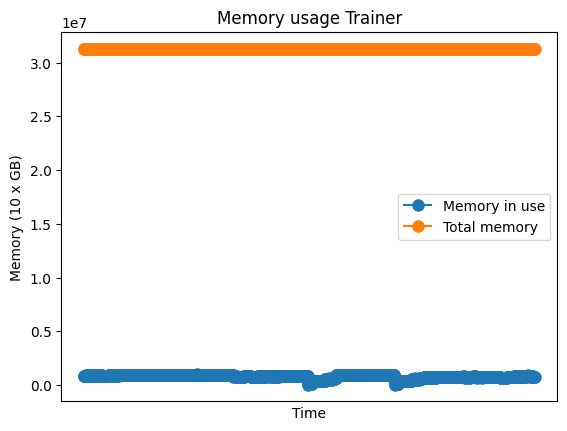

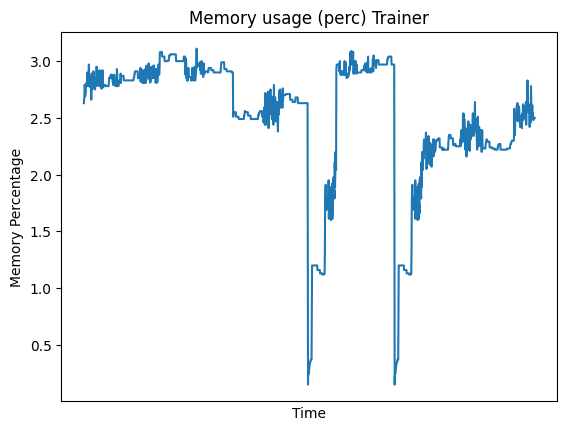

<Figure size 640x480 with 0 Axes>

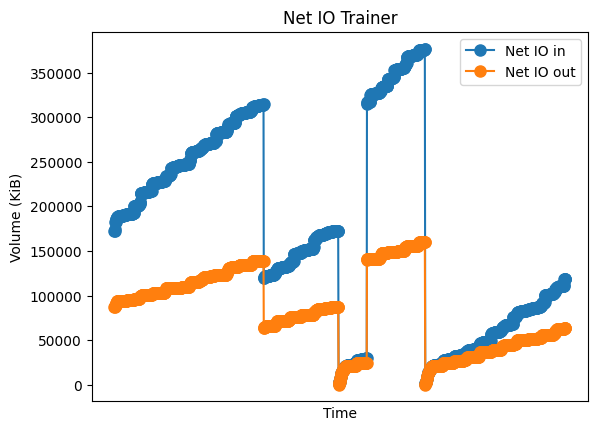

<Figure size 640x480 with 0 Axes>

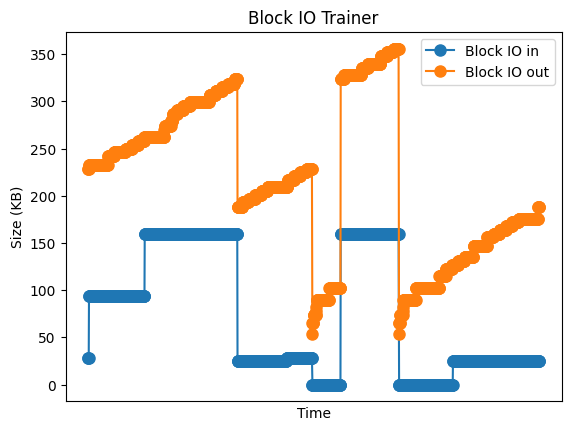

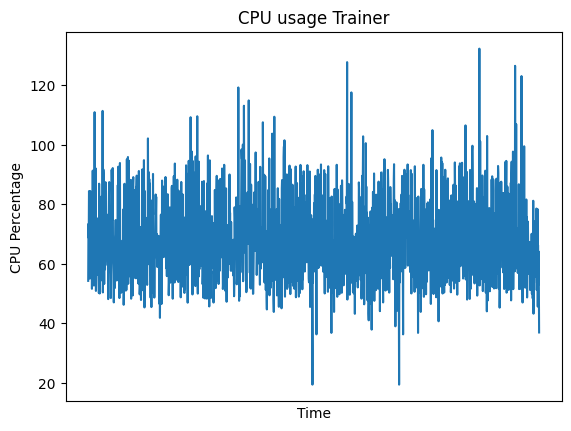

<Figure size 640x480 with 0 Axes>

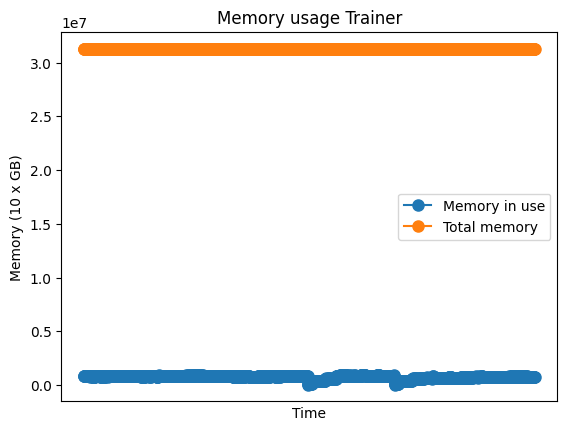

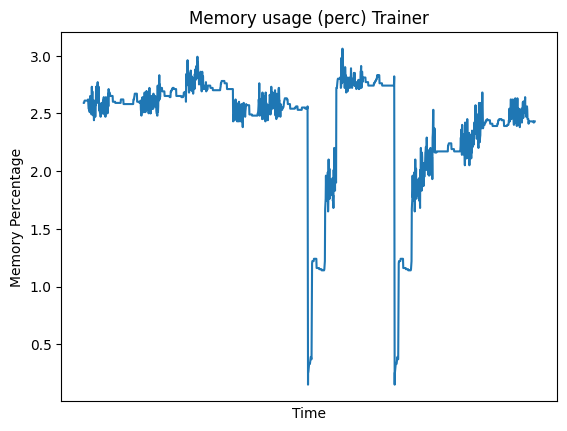

<Figure size 640x480 with 0 Axes>

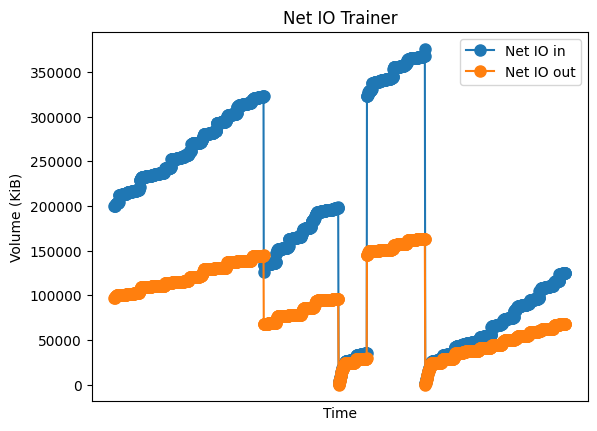

<Figure size 640x480 with 0 Axes>

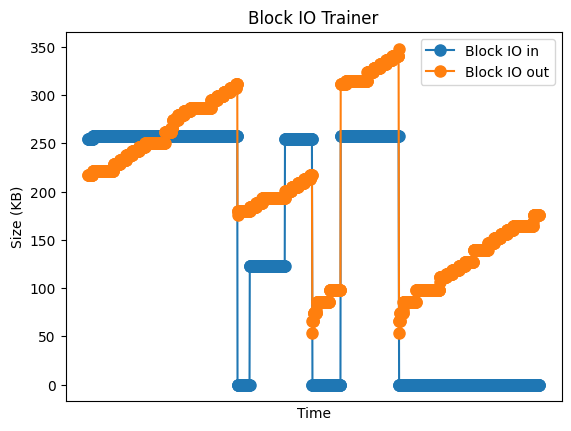

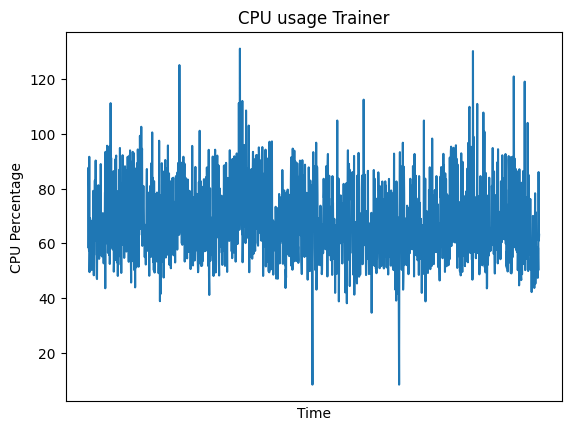

<Figure size 640x480 with 0 Axes>

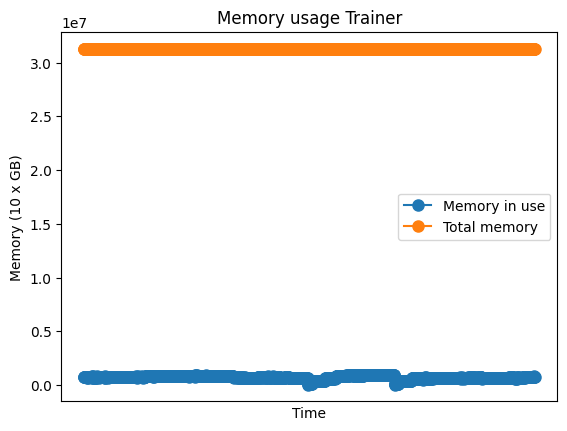

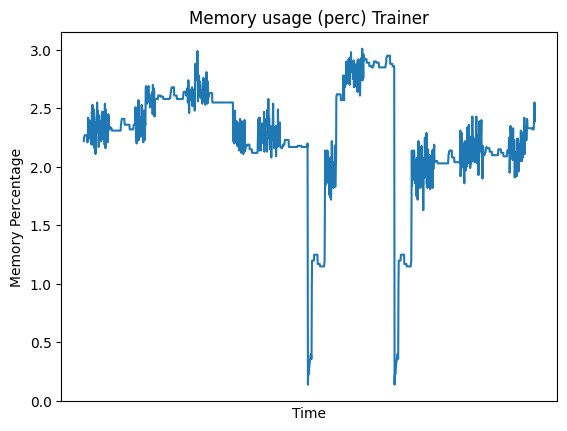

<Figure size 640x480 with 0 Axes>

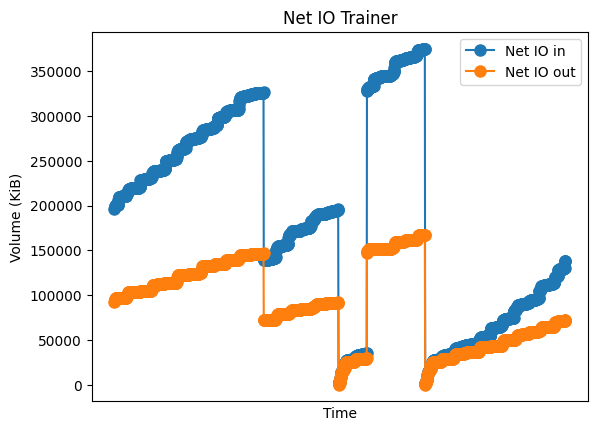

<Figure size 640x480 with 0 Axes>

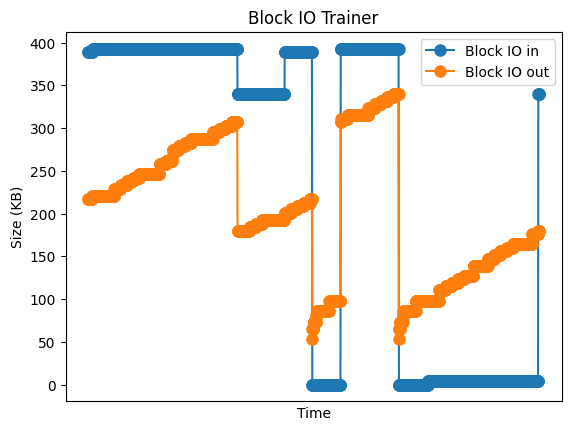

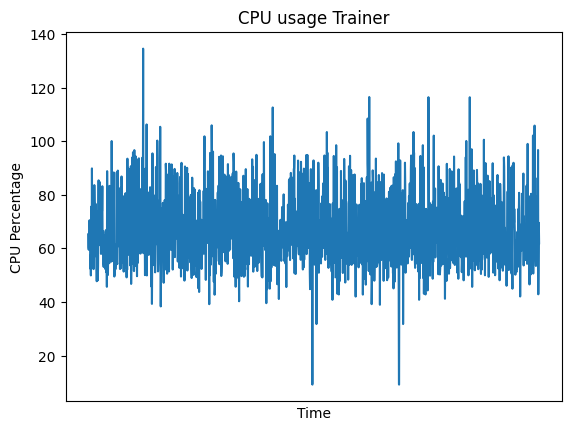

<Figure size 640x480 with 0 Axes>

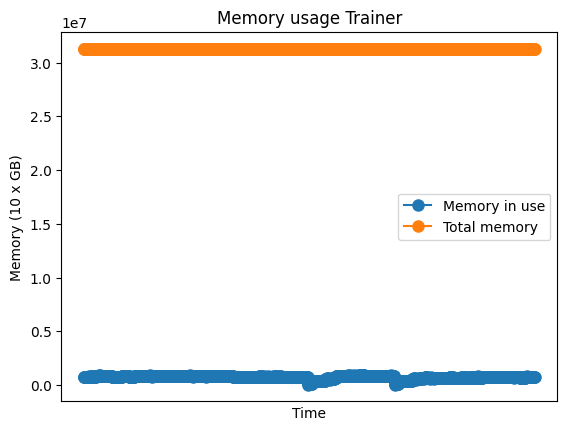

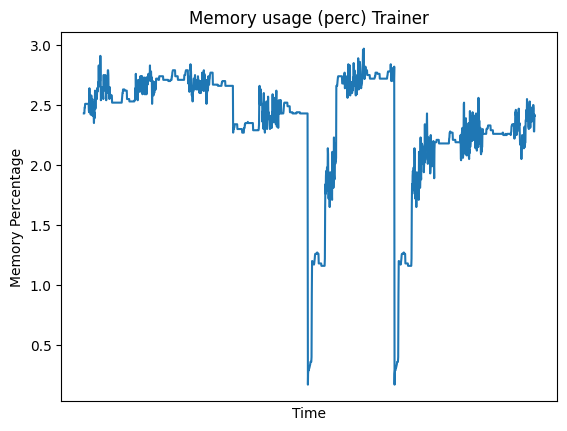

<Figure size 640x480 with 0 Axes>

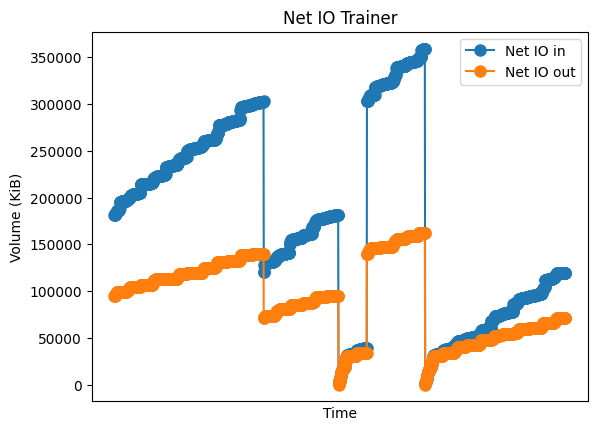

<Figure size 640x480 with 0 Axes>

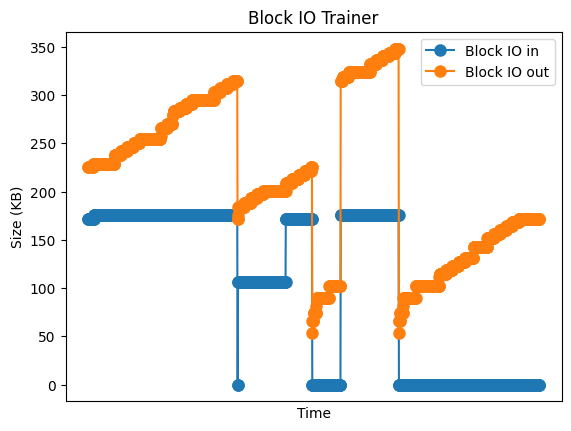

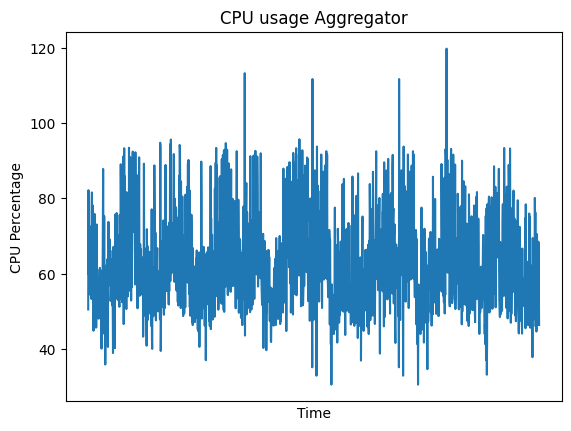

<Figure size 640x480 with 0 Axes>

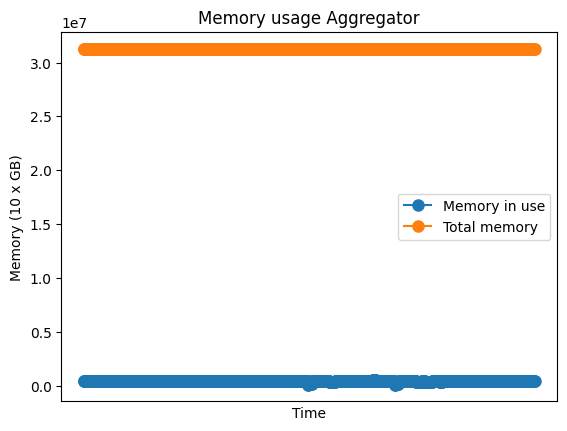

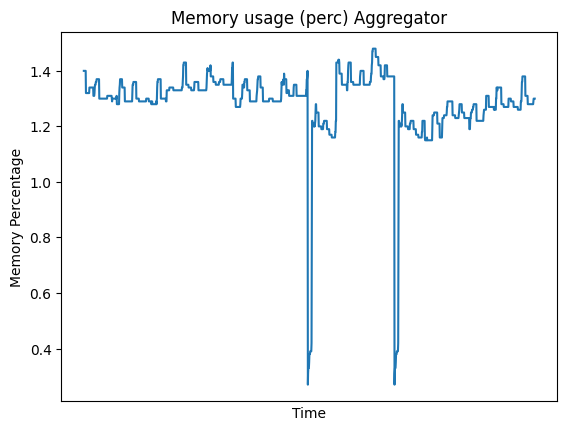

<Figure size 640x480 with 0 Axes>

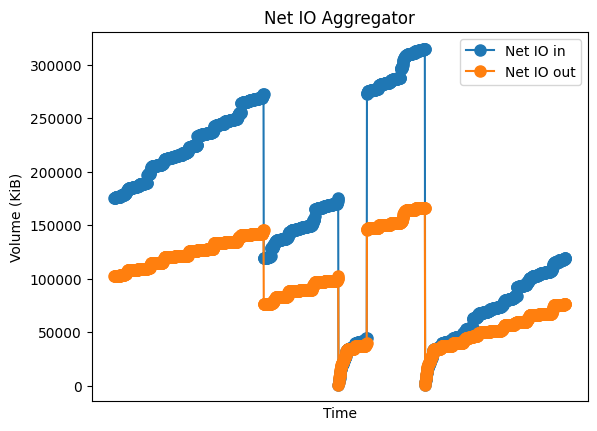

<Figure size 640x480 with 0 Axes>

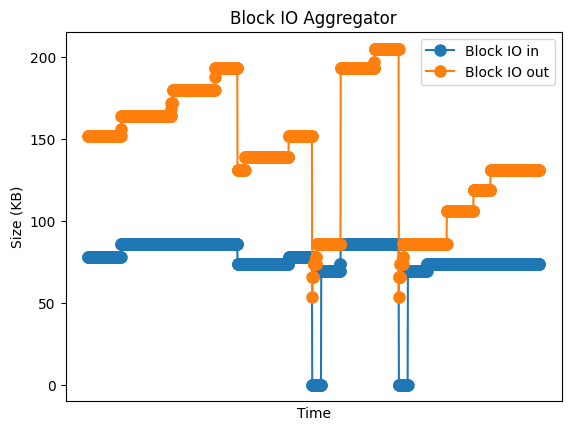

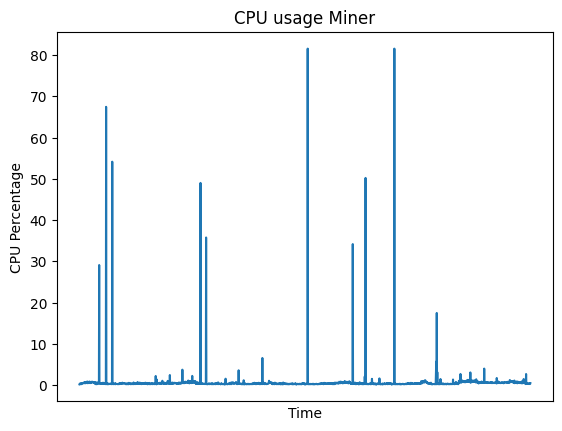

<Figure size 640x480 with 0 Axes>

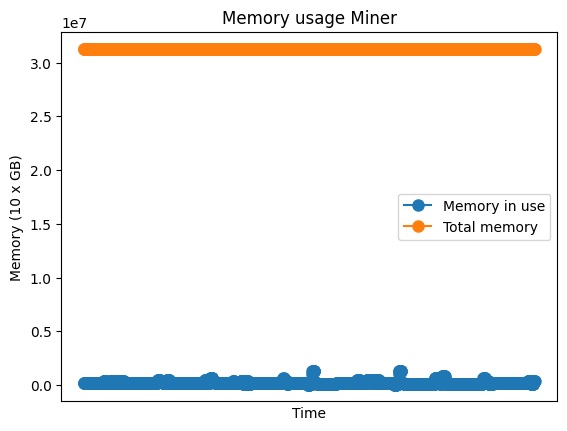

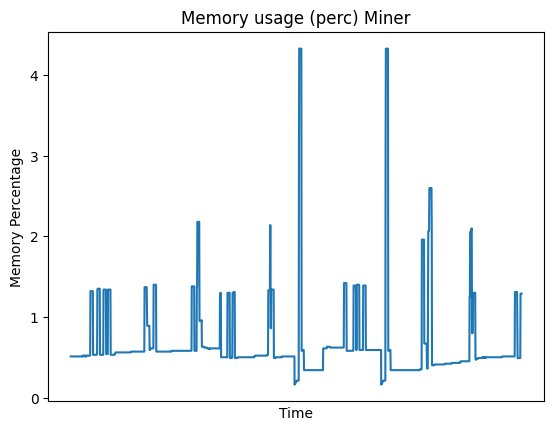

<Figure size 640x480 with 0 Axes>

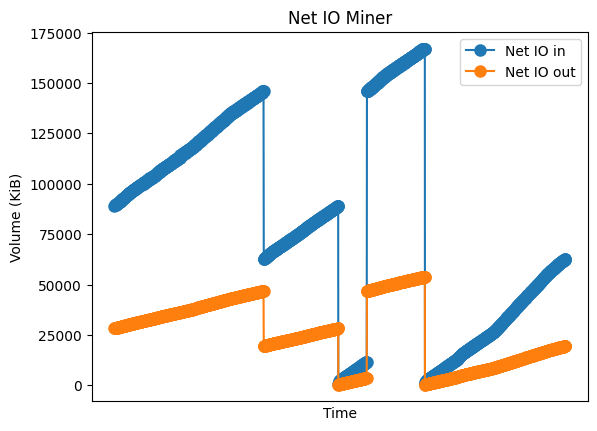

<Figure size 640x480 with 0 Axes>

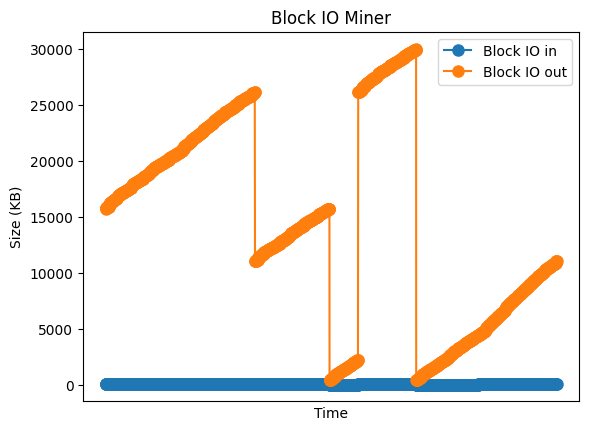

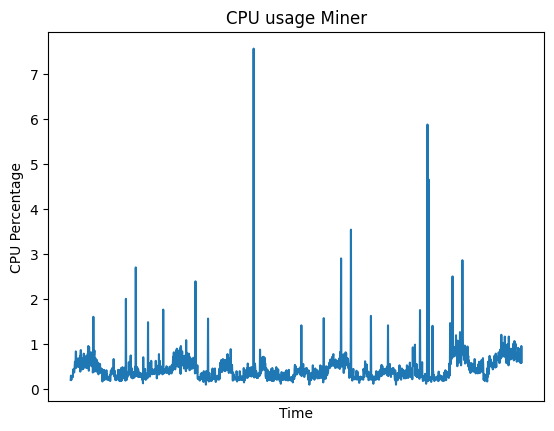

<Figure size 640x480 with 0 Axes>

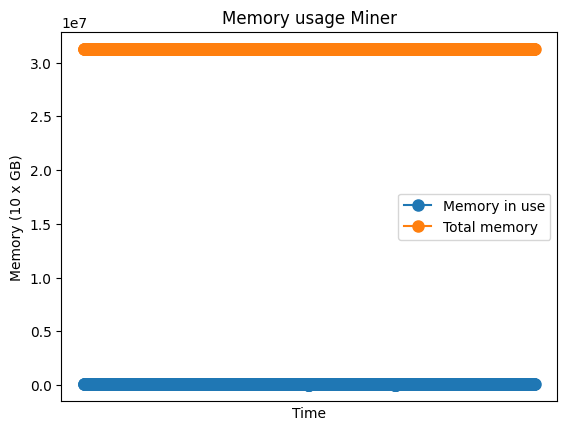

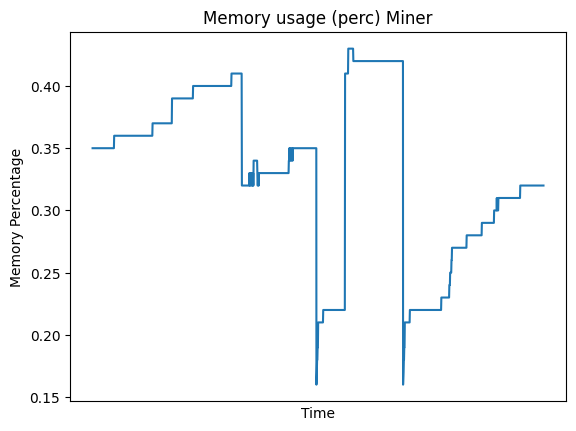

<Figure size 640x480 with 0 Axes>

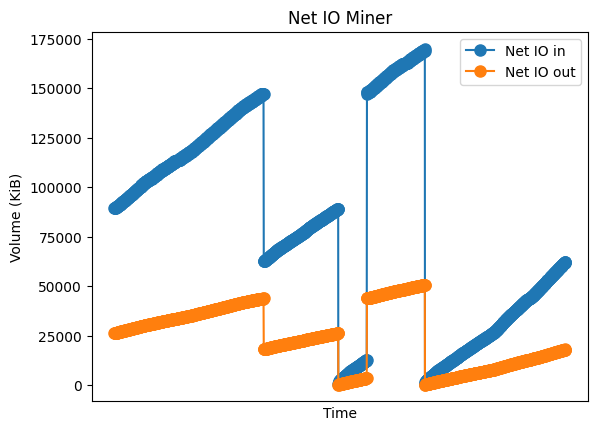

<Figure size 640x480 with 0 Axes>

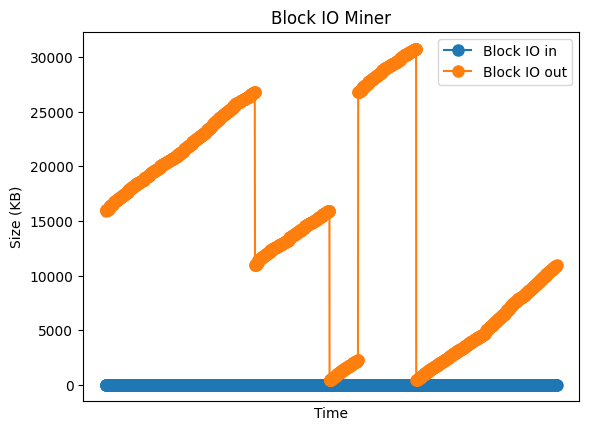

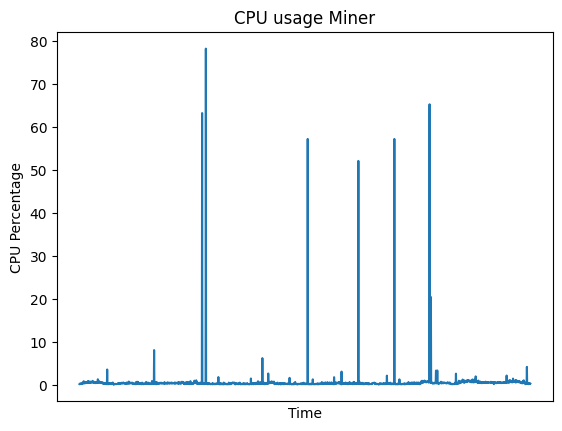

<Figure size 640x480 with 0 Axes>

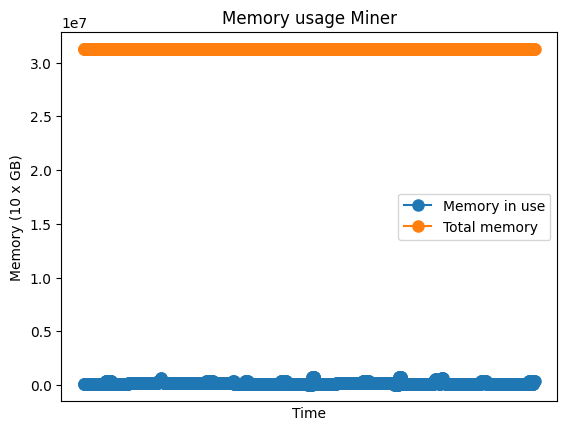

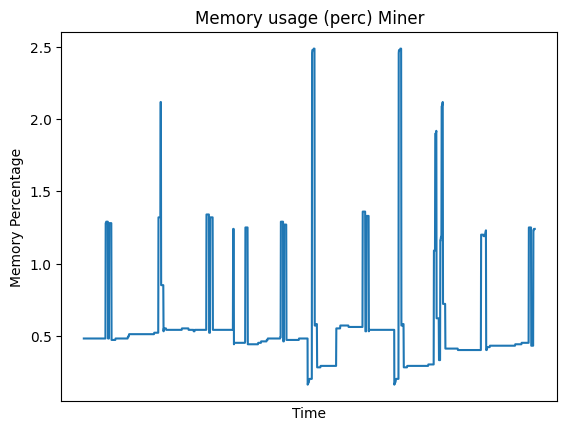

<Figure size 640x480 with 0 Axes>

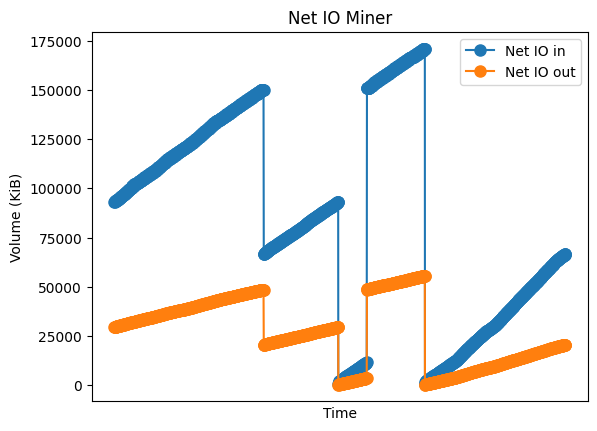

<Figure size 640x480 with 0 Axes>

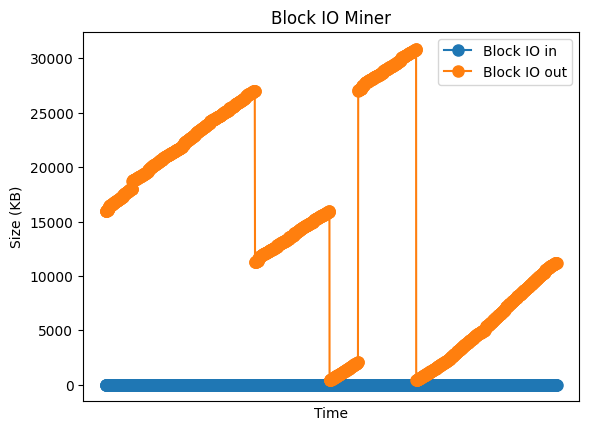

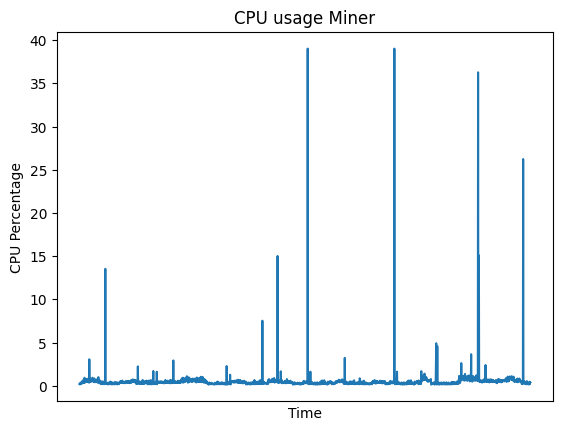

<Figure size 640x480 with 0 Axes>

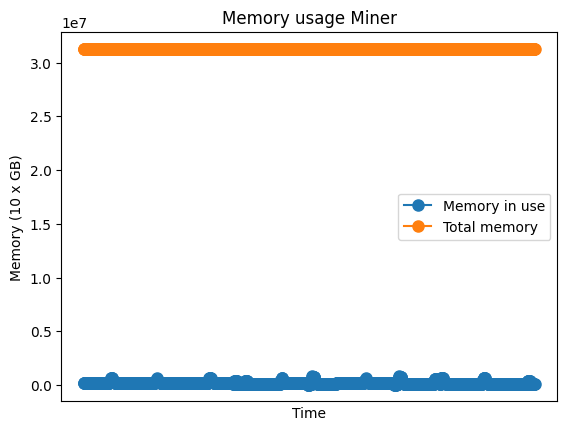

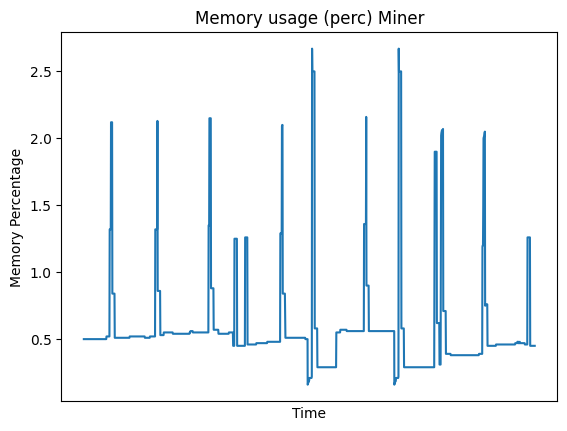

<Figure size 640x480 with 0 Axes>

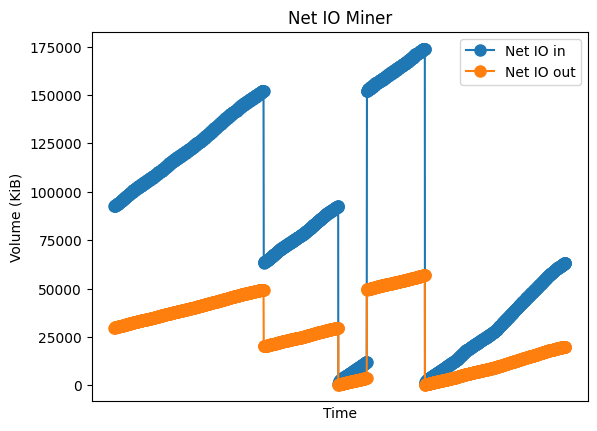

<Figure size 640x480 with 0 Axes>

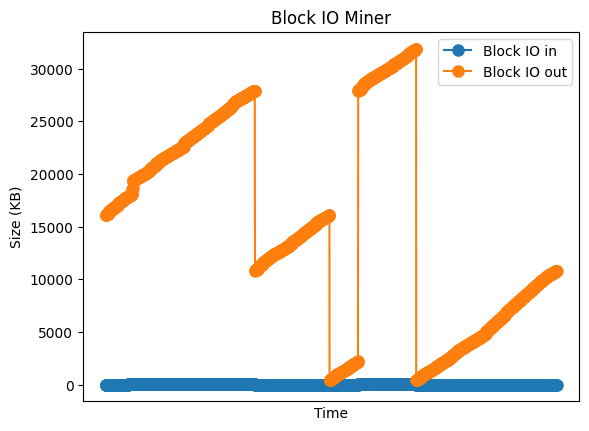

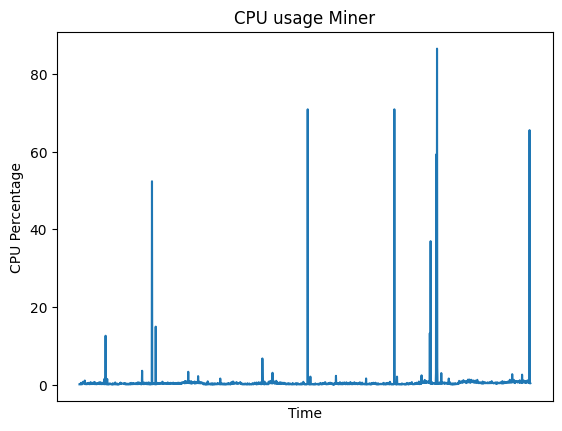

<Figure size 640x480 with 0 Axes>

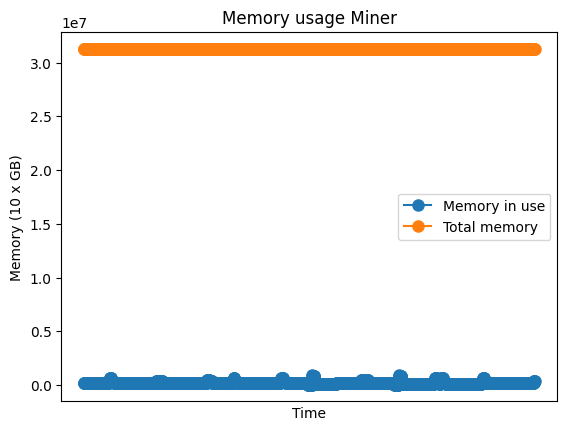

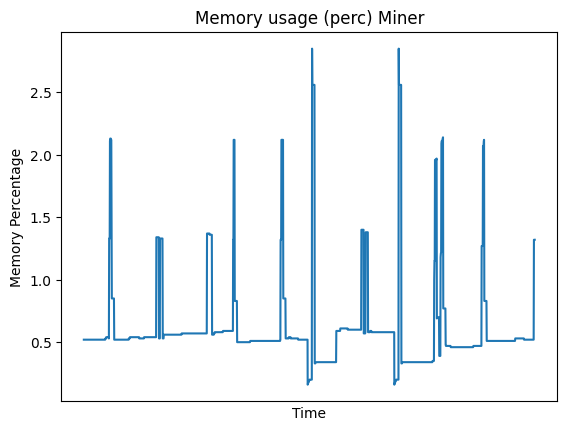

<Figure size 640x480 with 0 Axes>

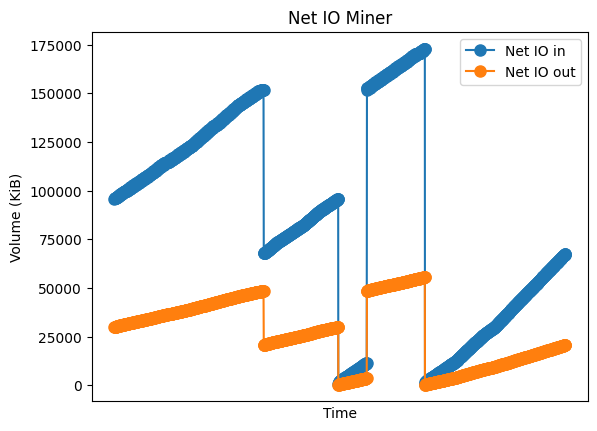

<Figure size 640x480 with 0 Axes>

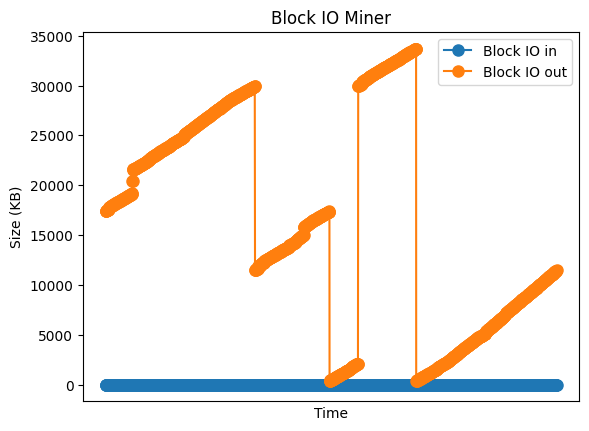

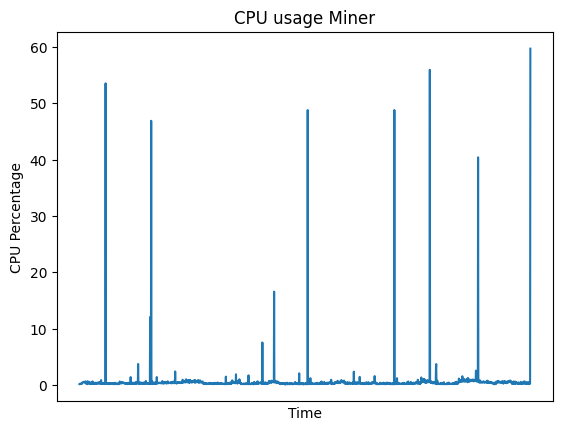

<Figure size 640x480 with 0 Axes>

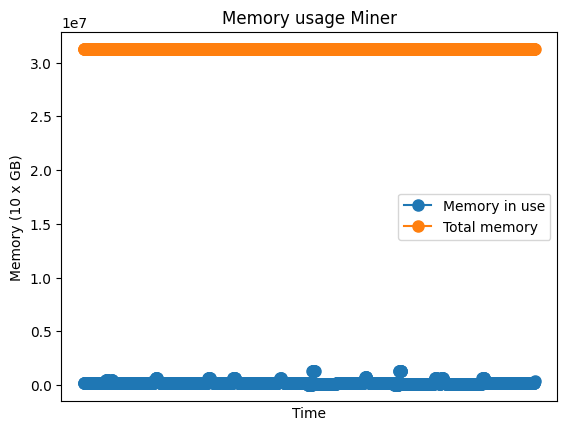

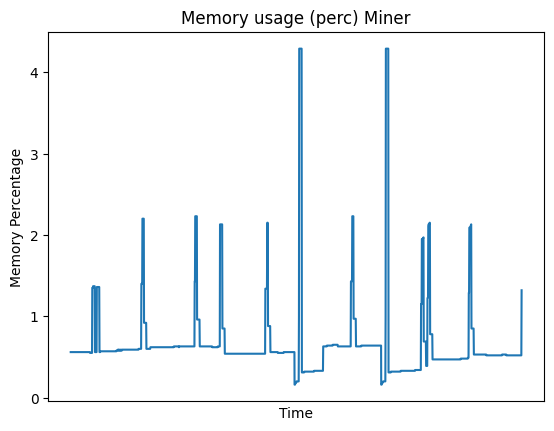

<Figure size 640x480 with 0 Axes>

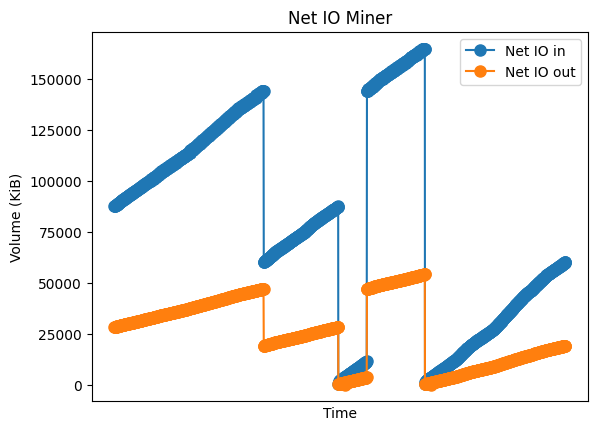

<Figure size 640x480 with 0 Axes>

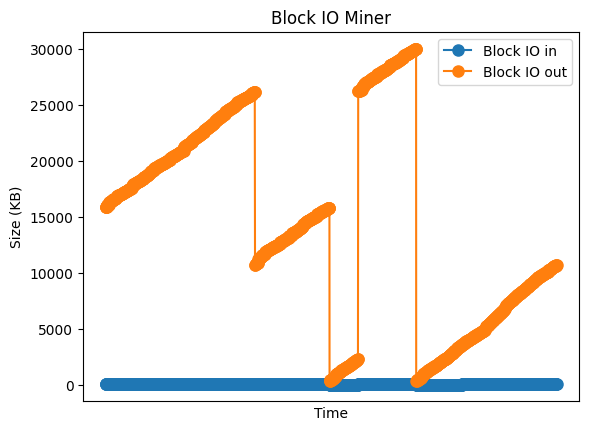

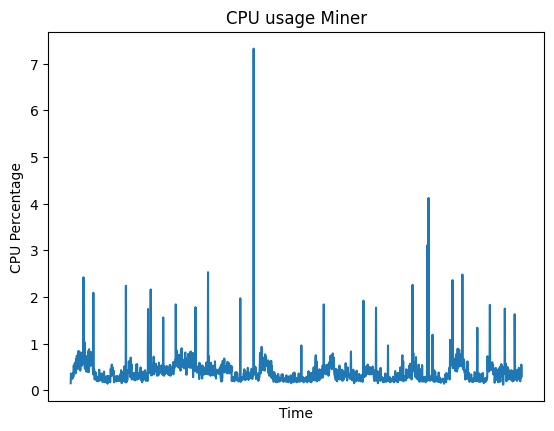

<Figure size 640x480 with 0 Axes>

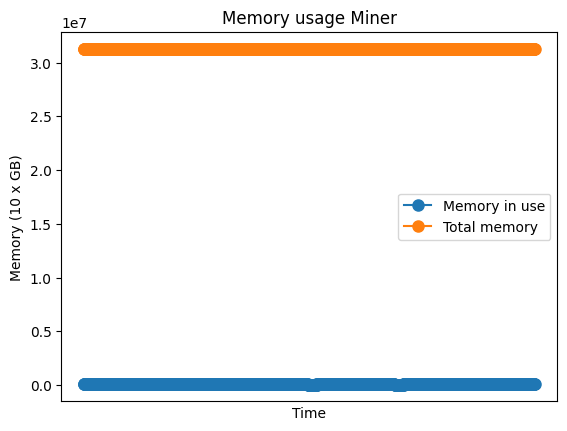

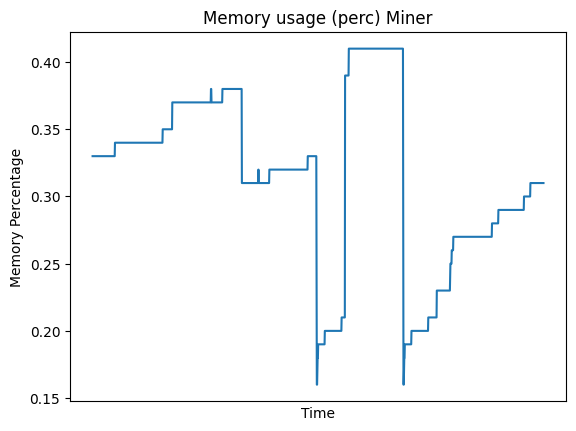

<Figure size 640x480 with 0 Axes>

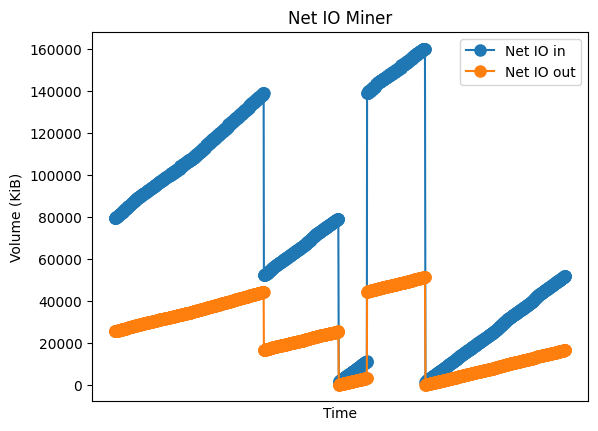

<Figure size 640x480 with 0 Axes>

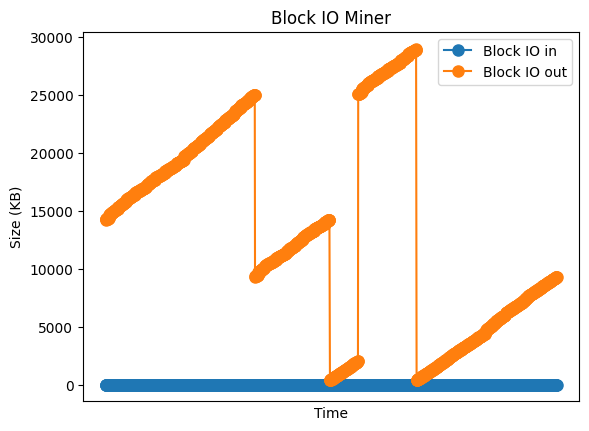

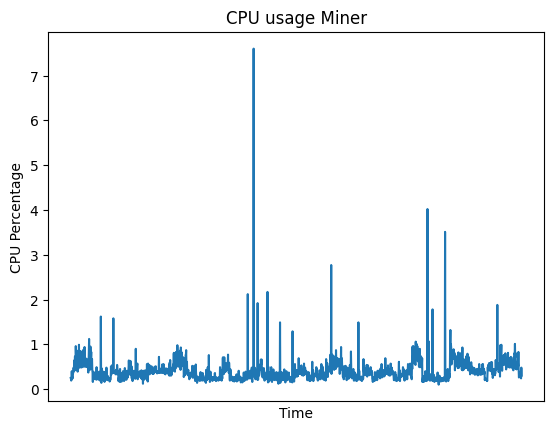

<Figure size 640x480 with 0 Axes>

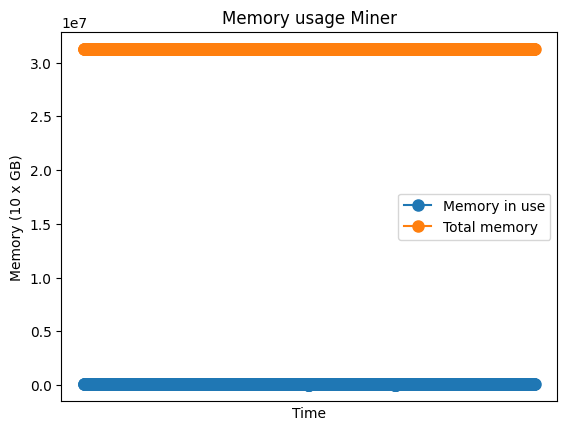

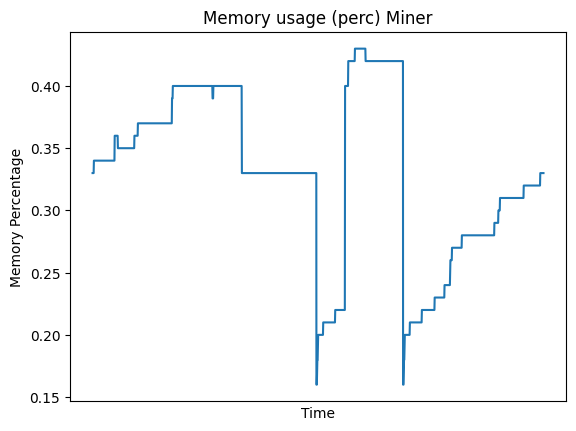

<Figure size 640x480 with 0 Axes>

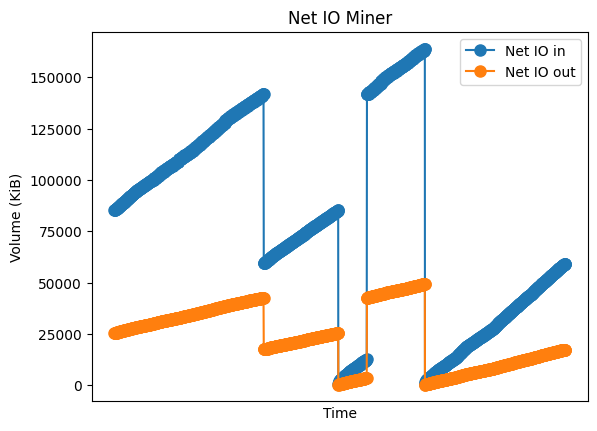

<Figure size 640x480 with 0 Axes>

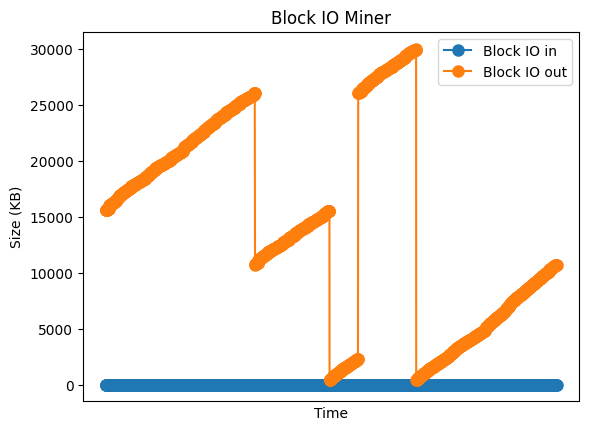

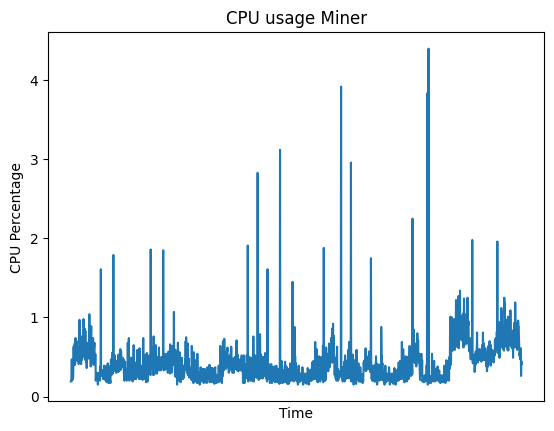

<Figure size 640x480 with 0 Axes>

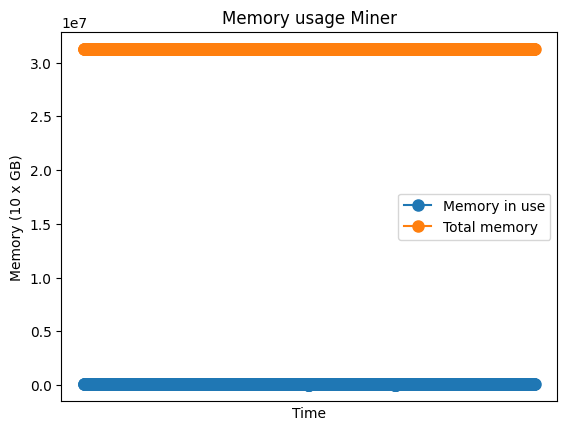

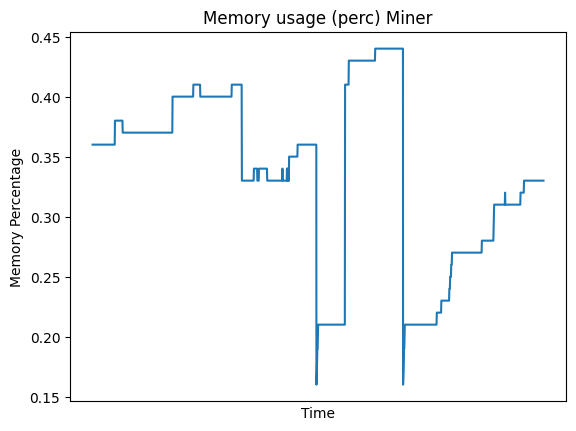

<Figure size 640x480 with 0 Axes>

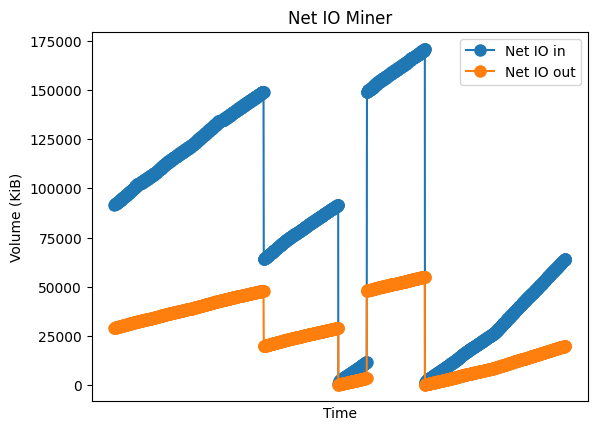

<Figure size 640x480 with 0 Axes>

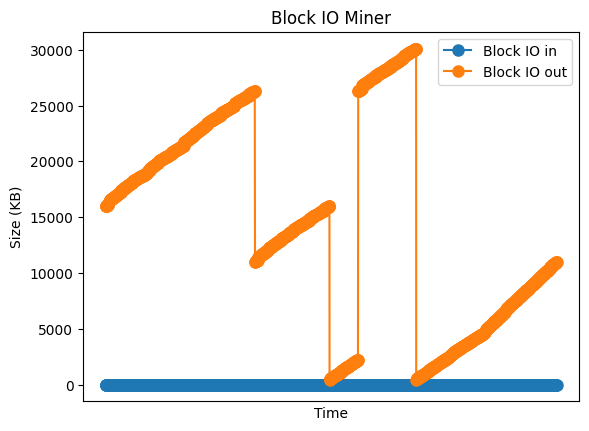

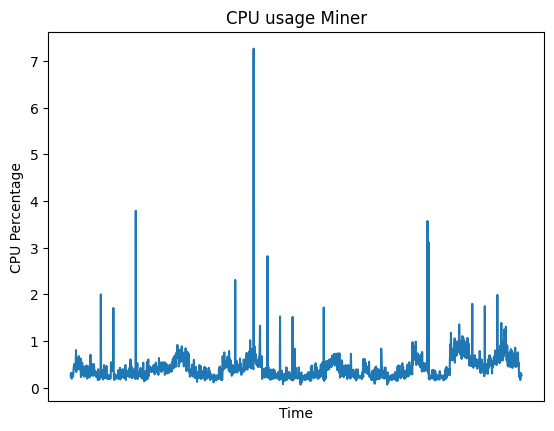

<Figure size 640x480 with 0 Axes>

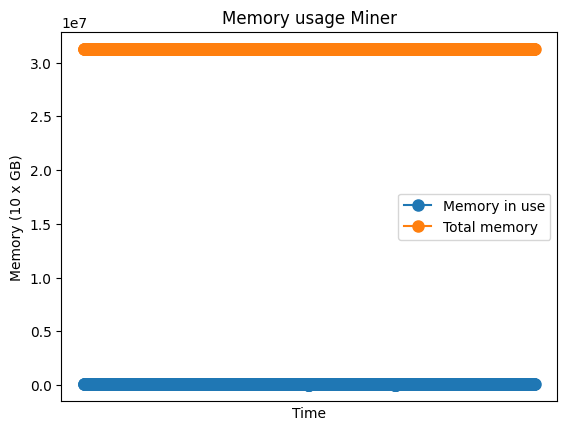

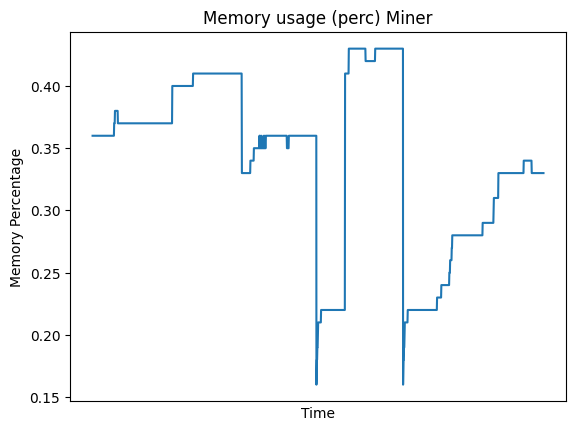

<Figure size 640x480 with 0 Axes>

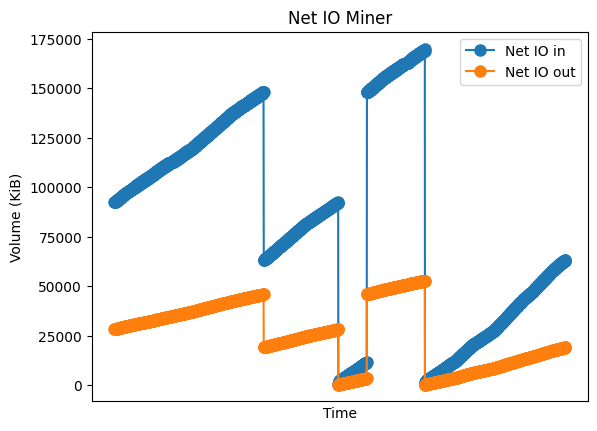

<Figure size 640x480 with 0 Axes>

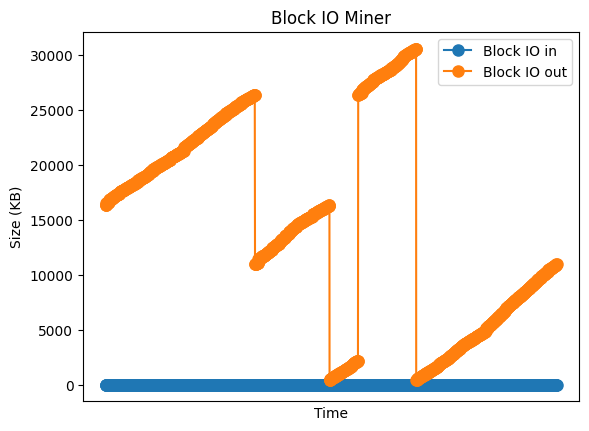

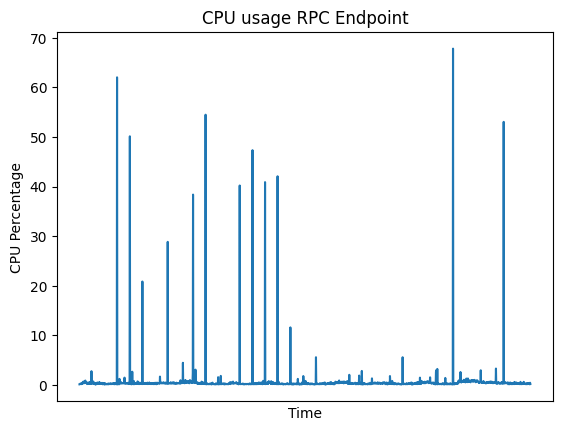

<Figure size 640x480 with 0 Axes>

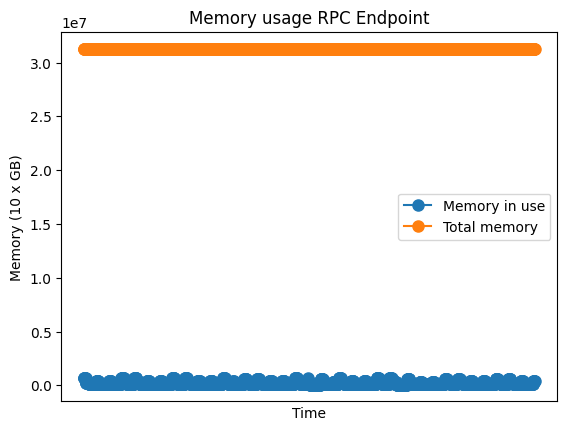

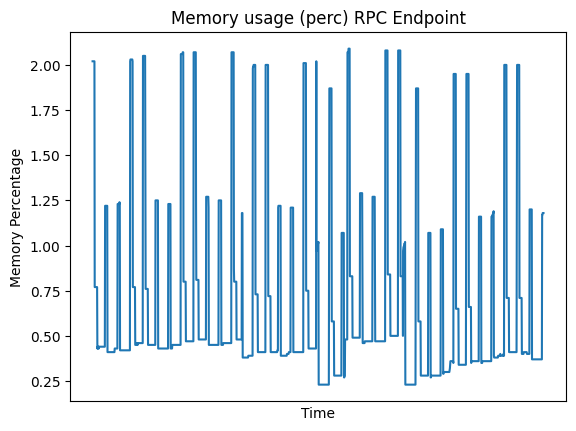

<Figure size 640x480 with 0 Axes>

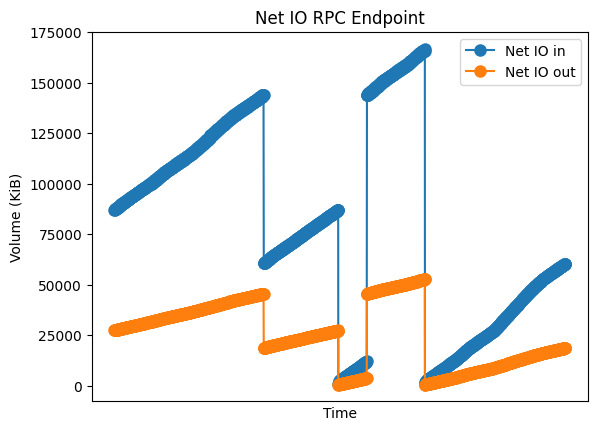

<Figure size 640x480 with 0 Axes>

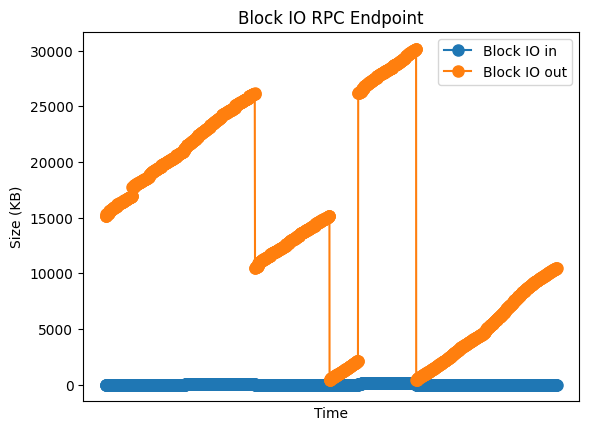

In [220]:

for name in names:
    do_cpu(name, df)
    do_mem(name, df)
    do_mem_perc(name, df)
    do_io(name, df)
    do_block_io(name, df)